In [122]:
import sys
# %conda install --yes --prefix {sys.prefix} pymatreader

from pymatreader import read_mat
from scipy import signal
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time

In [123]:
data = read_mat('D:\\Dissertation\\wifimod\\S1_S47\\I7\\S1_S47_I7_T1.mat')

In [124]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Raw_Cell_Matrix'])

In [125]:
df = pd.DataFrame(data['Raw_Cell_Matrix'])
# print(data['Raw_Cell_Matrix'])
df = df.drop(['Nrx', 'Ntx', 'noise','agc','RSSI_a', 'RSSI_b','RSSI_c', "timestamp_low"], axis=1)


In [126]:
def meanstd(df):
    test = df['Filtered'].copy()
    test = test.dropna(axis=0)
    # print(df['CSI'])
    for i in range(0, len(test)):
        test[i] = test[i].flatten()
    test = test.to_numpy()
    # print(test.shape)
    #Uncoment this line below, testing
    # test = np.column_stack(test) #Each array is the ith jth subcarrier of every sample
    # print(test.shape)
    # print(test[0])
    meanstd = [(np.mean(sample), np.std(sample)) for sample in test]
    # print([sample for sample in meanstd])
    # print(len(meanstd))
    return meanstd


def standardise2(data,ms): #Calculates mean of each subcarrier
    data = np.array(data).flatten()
  
    combined = list(zip(ms, data))
    resultList = []
    for value in combined:
        standardise = lambda x, y, z: (x-y)/z
        csistd = np.frompyfunc(standardise, 3, 1)
        result = csistd(value[1],value[0][0],value[0][1])
        resultList.append(result)

    return resultList
    
def filter(csi):
    nyq = 0.5*100 #Sampled at 100Hz
    low = 10/nyq #Cutoff below 10Hz
    high = 90/nyq
    b, a = signal.butter(2, [low,high], btype ='bandpass', analog=False, fs=100)
    return csi.apply(lambda csi: signal.filtfilt(b,a, csi))
    
def preprocess(df, active, steady):
    
    #Extracting the amplitude
    df['CSI'] = np.abs(df['CSI'])
    #Filtering
    df['Filtered'] = filter(df['CSI'])
    meanstdlist = meanstd(df)
    df['Standardised'] = [standardise2(sample, meanstdlist) for sample in df["Filtered"]]
    
    # df.drop("CSI", inplace = True, axis = 1)
    
    
    
# preprocess(df, 'I1','I13')
preprocess(df, 'I5', 'I13')
df.dropna(axis=0)
print(df)
# print(df.shape)
# print(df.loc[0].shape)
# display(df['Standardised'].loc[0])
    

                                                    CSI label  \
0     [[[32.01562118716424, 29.966648127543394, 31.7...   I13   
1     [[[29.410882339705484, 43.278170016764804, 38....   I13   
2     [[[26.627053911388696, 30.805843601498726, 34....   I13   
3     [[[28.160255680657446, 28.42534080710379, 29.1...   I13   
4     [[[31.38470965295043, 29.427877939124322, 29.2...   I13   
...                                                 ...   ...   
1615  [[[24.041630560342615, 29.017236257093817, 25....    I7   
1616  [[[23.853720883753127, 31.400636936215164, 28....    I7   
1617  [[[20.248456731316587, 21.37755832643195, 29.0...    I7   
1618  [[[21.840329667841555, 26.076809620810597, 29....    I7   
1619  [[[25.019992006393608, 29.614185789921695, 26....    I7   

                                               Filtered  \
0     [[[6.93244895865594, 7.810440091842456, 8.6415...   
1     [[[6.134253313760602, 7.42927742853282, 8.6766...   
2     [[[5.907362458770165, 7.077000131980

In [127]:
check = df['Standardised']
type(check[0])

list

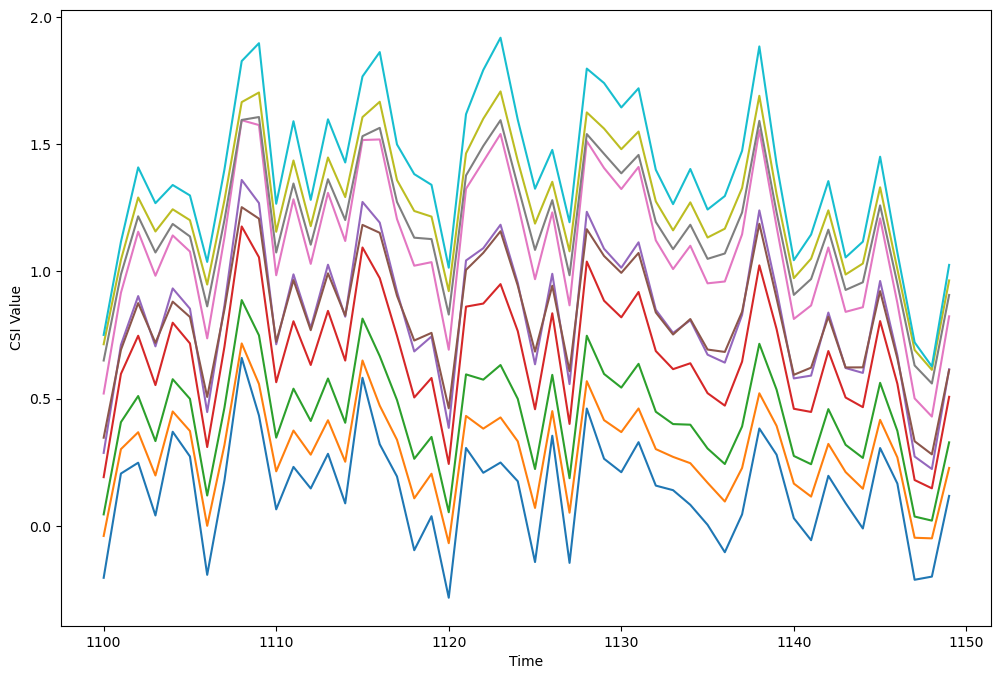

In [128]:
def plotFiltered():
    testpl = df['Standardised'].copy()
    testpl = np.column_stack(testpl) #Each array is the ith jth subcarrier of every sample
    plt.figure(figsize=(12,8))
    x = range(1100,1150)
    for i in range(10):
        # y = testpl[0][400:450]
        y = testpl[i][1100:1150]
        plt.plot(x, y)

    plt.xlabel('Time')
    plt.ylabel('CSI Value')
    plt.show()
    
plotFiltered()

(180,)
(180, 1620)


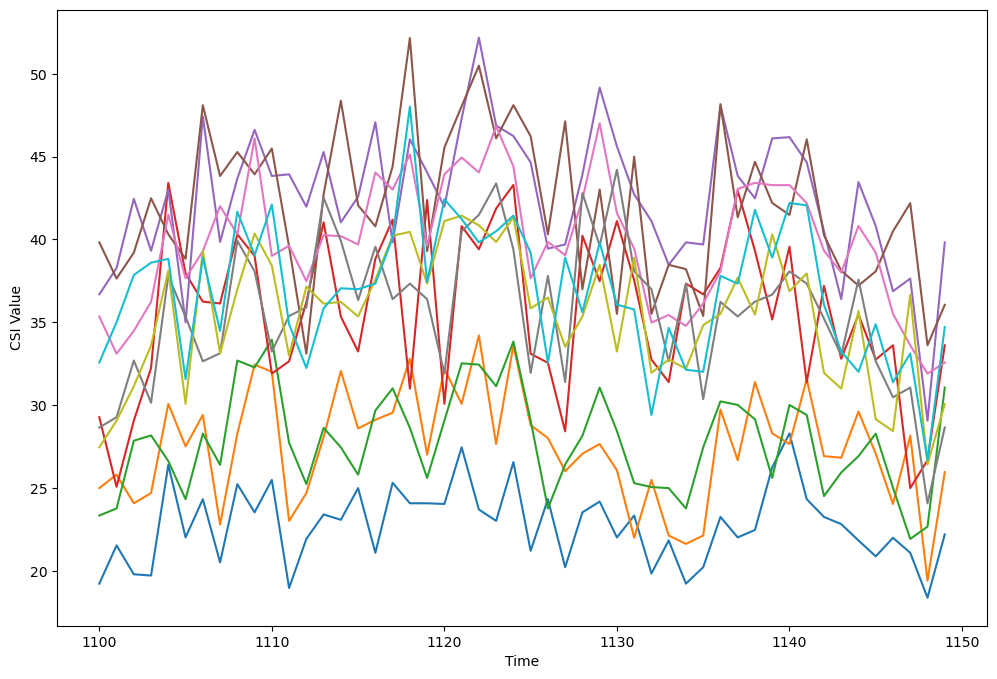

In [129]:
def plotRaw():
    testpl = df['CSI'].copy()
    # testpl = np.column_stack(testpl) #Each array is the ith jth subcarrier of every sample
    testpl = testpl.apply(lambda x : x.flatten())
    print(testpl[0].shape)
    testpl = np.column_stack(testpl) #Each array is the ith jth subcarrier of every sample
    print(testpl.shape)
    plt.figure(figsize=(12,8))
    x = range(1100,1150)
    for i in range(10):
        # y = testpl[0][400:450]
        y = testpl[i][1100:1150]
        plt.plot(x, y)

    plt.xlabel('Time')
    plt.ylabel('CSI Value')
    plt.show()
    
plotRaw()

In [93]:
def segmentation(df):
    #Window size is 256, stride is 128
    segmented = pd.DataFrame({'Range': 'string', 'Sample': []})
    stride = 128
    startIndex = 0
    lastIndex = 256
    while(lastIndex < df.shape[0]):
        sample = df['Standardised']
        sample = sample.iloc[startIndex:lastIndex].to_numpy()
        index = '{}-{}'.format(startIndex, lastIndex)
        newRow = pd.Series({'Range' : index, 'Sample' : sample})
        segmented = pd.concat([segmented, newRow.to_frame().T], ignore_index=True)
        startIndex += stride
        lastIndex += stride

    return segmented
    
preprocessed = pd.DataFrame({'Range': '', 'Sample': [], 'Label': ''})

int1 = df.loc[df["label"] == "I5"]
int13 = df.loc[df["label"] == "I13"]

# int('Grouped')
segmentF = segmentation(int1)
segmentF['Label'] = ["I5" for sample in segmentF['Range']]
print(segmentF)
segmentS = segmentation(int13)
segmentS['Label'] = ["I13" for sample in segmentS['Range']]

preprocessed = pd.concat([preprocessed, segmentF], ignore_index=True)
preprocessed = pd.concat([preprocessed, segmentS], ignore_index=True)
print(preprocessed)
test = preprocessed['Sample'].copy()
print(preprocessed.shape)


     Range                                             Sample Label
0    0-256  [[0.04180500505545306, 0.30477319580548373, 0....    I5
1  128-384  [[-0.1276535913063931, 0.12578134393417328, 0....    I5
2  256-512  [[-0.474656981103296, -0.1837396214896971, -0....    I5
3  384-640  [[-0.20472702277237437, 0.01013243203679215, 0...    I5
4  512-768  [[-0.5791838780962015, -0.3545179236810253, -0...    I5
5  640-896  [[0.08715704265078468, 0.23754355608348812, 0....    I5
     Range                                             Sample Label
0    0-256  [[0.04180500505545306, 0.30477319580548373, 0....    I5
1  128-384  [[-0.1276535913063931, 0.12578134393417328, 0....    I5
2  256-512  [[-0.474656981103296, -0.1837396214896971, -0....    I5
3  384-640  [[-0.20472702277237437, 0.01013243203679215, 0...    I5
4  512-768  [[-0.5791838780962015, -0.3545179236810253, -0...    I5
5  640-896  [[0.08715704265078468, 0.23754355608348812, 0....    I5
6    0-256  [[0.13361525116726128, 0.38681588254

In [94]:
len(test[0][0])

180

In [98]:
testseg = preprocessed['Sample'][2].copy()
# testpl = df['CSI'].copy()
# testpl = [sample.flatten() for sample in testpl]
# testpl = np.transpose(testpl)
# print(testpl)
testseg = np.column_stack(testseg) #Each array is the ith jth subcarrier of every sample

print(testseg.shape)
# 
# print(testpl)

print(testseg[0])



(180, 256)
[-4.74656981e-01 -8.48672980e-01 -5.42200413e-01 -7.78033316e-01
 -4.14914215e-01 -1.30146011e+00 -8.67811167e-01 -1.00057871e+00
 -8.41366089e-01 -6.71266081e-01 -1.11763456e+00 -8.97563364e-01
 -2.90763991e-01 -4.91770934e-01 -9.42766456e-01 -7.26109749e-01
 -4.03532139e-01 -5.47178659e-01 -8.71006335e-01 -8.07975380e-01
 -8.23544909e-01 -8.68632927e-01 -1.25774992e+00 -9.85521162e-01
 -5.88818138e-01 -7.67862590e-01 -7.71797057e-01 -7.23449646e-01
 -4.21467036e-01 -6.87648415e-01 -9.62048149e-01 -9.61010532e-01
 -7.06929821e-01 -6.93775257e-01 -8.73343073e-01 -1.08980742e+00
 -8.97014546e-01 -8.05442178e-01 -9.06790397e-01 -7.47058115e-01
 -1.01299096e+00 -1.04025426e+00 -8.02740188e-01 -6.77667547e-01
 -9.67649104e-01 -8.88506089e-01 -7.60105333e-01 -3.68578332e-01
 -5.93821130e-01 -6.17620379e-01 -6.70979210e-01 -5.26654802e-01
 -6.54697466e-01 -9.33818420e-01 -8.21873612e-01 -9.66597895e-01
 -7.81109298e-01 -6.98633203e-01 -7.10956633e-01 -7.39325799e-01
 -4.51546550e-

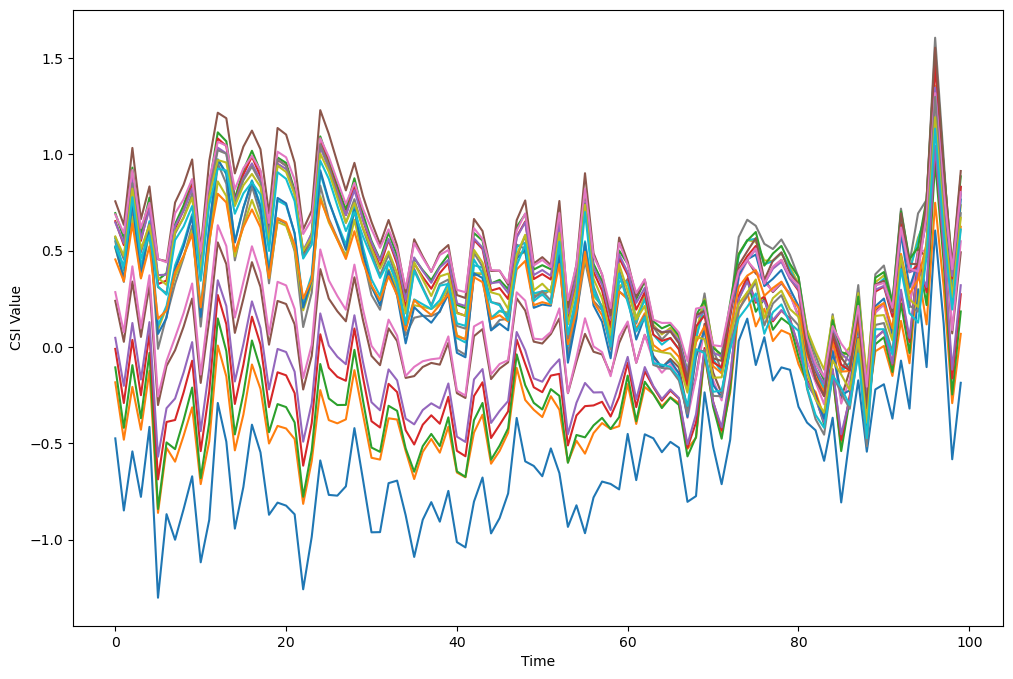

In [104]:
plt.figure(figsize=(12,8))
x = range(0,100)
for i in range(20):
    # y = testpl[0][400:450]
    y = testseg[i][0:100]
    plt.plot(x, y)

plt.xlabel('Time')
plt.ylabel('CSI Value')
plt.show()